In [351]:
import numpy as np
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
import string
from sklearn.utils import shuffle
from sklearn import neighbors
import matplotlib.pyplot as plt

In [312]:
def parseData(file, read_limit):
    null = None
    with open(file, errors='ignore') as f:
        i=0
        for l in f:
            if i<read_limit:
                i+=1
                x = eval(l)
                yield x
            else:
                break
            
def LoadData(f, read_limit = 100000):
    return list(parseData(f, read_limit))

business_data = LoadData('yelp_academic_dataset_business.json')
review_data = LoadData('yelp_academic_dataset_review.json')
tip_data = LoadData('yelp_academic_dataset_tip.json')

In [313]:
cat_dict = defaultdict(int)
biz_cat_map = defaultdict(list)
for data in business_data:
    if data['categories'] != None:
        biz_cat_map[data['business_id']] = data['categories']
        for cat  in data['categories']:
            cat_dict[cat]+=1
            
#years = [d['date'].split('-')[0] for d in data]
#data[0]['date'].split('-')[0]
sort_cat =  sorted(cat_dict.items(), key=lambda x:x[1])[-50:]
sort_cat.reverse()
sorted_cat = [d[0] for d in sort_cat]

In [314]:
n_top_words = 15
n_feat = 1500
n_topics = 50

topic_words = defaultdict(list)
topic_group = defaultdict(list)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            #print(feature_names[i])
            topic_words[topic_idx].append(feature_names[i])
            topic_group[feature_names[i]].append(topic_idx)
        
    print()

train = int(len(review_data)/2)
corpus = [d['text'] for d in review_data[train:] if len(biz_cat_map[d['business_id']])> 0]

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', max_df=0.95, min_df=2)
tfidf = tfidf_vectorizer.fit_transform(corpus)

nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)


Topics in NMF model:
Topic #0:
said told didn went asked called day came minutes took wanted phone left later wasn
Topic #1:
und die der das ist ich sehr nicht auch es mit war ein zu man
Topic #2:
food fast eat mexican atmosphere chinese fresh quality service bad authentic wait delicious eating portions
Topic #3:
great atmosphere awesome experience fun selection thanks deal spot definitely loved friends variety music family
Topic #4:
store items selection stores shopping buy clothing sales clothes shoes products grocery helpful sale stuff
Topic #5:
service customer excellent worst rude slow horrible friendly fast poor manager terrible quick received product
Topic #6:
et le la est pour les une des en pas que dã plus es ambiance
Topic #7:
hair cut salon stylist haircut color style appointment wanted look does products looking doing want
Topic #8:
dr office dentist care doctor pain patient appointment treatment insurance staff feel visit health wonderful
Topic #9:
good pretty selection b

In [315]:
def divide_shuffle(X, Y_cat):
    X, Y = shuffle(X, Y_cat, random_state=0)
    train = int(len(X)/2)
    X_train = X[:train]
    Y_train = Y[:train]
    X_test = X[train:]
    Y_test = Y[train:]
    return X_train, Y_train, X_test, Y_test

In [316]:
punctuation = set(string.punctuation)
wordCount = defaultdict(int)
bigramCount = defaultdict(int)

def parse(review):
    return ''.join([c for c in review.lower() if not c in punctuation])
    
def process(review):
    r = parse(review)
    words = r.split()
    for w in words:
        wordCount[w]+=1
    for i in range(len(words) - 1):
        bigramCount[(words[i], words[i+1])]+=1
    return r;

def get_group_member_vector(review):
    feat = [0]*n_topics
    r = parse(review)
    words = r.split()
    for word in words:
        indices = topic_group[word]
        for index in indices:
            feat[index]+=1
    return feat;

Y_cat_allhot=[]
for data in review_data:
    biz_id = data['business_id']
    biz_cat = biz_cat_map[biz_id]
    Y_re = []
    if len(biz_cat) > 0: 
        for i in range(len(sort_cat)):
            if sorted_cat[i] in biz_cat:
                Y_re.append(i)
        Y_cat_allhot.append(Y_re)

In [317]:
X = [get_group_member_vector(d['text']) for d in review_data if len(biz_cat_map[d['business_id']])>0]
X_train, Y_train, X_test, Y_test = divide_shuffle(X, Y_cat_allhot)

Y_train = MultiLabelBinarizer().fit_transform(Y_train)
Y_test = MultiLabelBinarizer().fit_transform(Y_test)

Y_normlizer = np.sum(Y_train, axis=0)

In [277]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(X_train)
X_new_train = pca.transform(X_train)
X_new_test = pca.transform(X_test)

In [290]:
clf = neighbors.RadiusNeighborsClassifier(radius=4, weights='distance')
clf.fit(X_train, Y_train)

RadiusNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, outlier_label=None, p=2, radius=4,
             weights='distance')

In [190]:
#print("training score : %.3f (%s)" % (clf.score(X_train, Y_train), 'multinomial'))
#print("training score : %.3f (%s)" % (clf.score(X_test, Y_test), 'multinomial'))

In [318]:
clf_lin = neighbors.KNeighborsClassifier(n_neighbors=20, weights='distance')
clf_lin.fit(X_train, Y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='distance')

In [69]:
def calc_loss(clf, X, Y):
    res = 0.0
    print ("total:" + str(len(X)))
    for i in range(len(X)):
        nn_idx = clf.radius_neighbors([X[i]], return_distance=False)[0]
        y_pred = (np.sum([Y_test[i] for i in nn_idx], axis=0)> len(nn_idx)/2)*1
        #y_pred = clf.predict([X[i]])
        res+=(np.linalg.norm(y_pred-Y[i]))
    return res/len(Y)
calc_loss(clf, X_train, Y_train)

total:8997


1.3875988864568731

In [70]:
calc_loss(clf, X_test, Y_test)

total:8997


1.3796330565736359

In [77]:
for i in Y_cat_allhot[0]:
    print(sorted_cat[i])

Restaurants
Nightlife
Bars
American (Traditional)


In [81]:
biz_cat_map[X_biz_id[0]]

['Nightlife', 'American (Traditional)', 'Pubs', 'Restaurants', 'Bars']

In [80]:
X_biz_id = [(d['business_id']) for d in review_data if len(biz_cat_map[d['business_id']])>0]

In [93]:
nn_idx = clf.radius_neighbors([X_train[0]], return_distance=False)[0]
y_pred = (np.sum([Y_train[i] for i in nn_idx], axis=0)> len(nn_idx)/10)*1

In [94]:
kneighbors

In [95]:
np.sum(t, axis = 0)

array([676, 115, 257,  37,  28,  44, 138, 122,  17,  22,  42,  49,  38,
        36,  63,  48,  33,  66,  13,  38,  42, 102,   9,   2,  30,  47,
        12,  15,   2,  22,  19,   8,  47,   9,   6,  14,  26,  34,  68,
         9,  30,   2,  16,  26,   4,   6,  28,   5,   4,   3])

In [102]:
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        print(sorted_cat[i])

Restaurants
Food
Nightlife
Bars


In [343]:
sorted_cat = np.array(sorted_cat)
miss_cat = defaultdict(int)
miss_business_list =[]
def calc_loss(clf, X, T, Y_train, radius = 4, distance_factor=10):
    miss_count=0
    miss_business = 0
    all_real=0
    #print ("total:" + str(len(X)))
    for i in range(len(X)):
        nn_idx = []
        nn_idx = clf.kneighbors([X[i]], return_distance=False)[0]
        temp_radius = radius
        #while len(nn_idx) <= 10 :
        #    nn_idx = clf.radius_neighbors([X[i]], radius=temp_radius, return_distance=False)[0]
        #    temp_radius += 0.5
        #print(len(nn_idx))
        y_pred = (np.sum([Y_train[i] for i in nn_idx], axis=0)> len(nn_idx)/distance_factor)*1
        #y_pred = clf.predict([X[i]])[0]
        #print (y_pred)
        T_cat = [j for j in range(len(T[i])) if T[i][j] == 1]
        Y_cat = [j for j in range(len(y_pred)) if y_pred[j] == 1]
        tagged = False
        for real_cat in T_cat:
            all_real+=1
            if real_cat not in Y_cat:
                miss_count+=1
                miss_cat[real_cat] += 1
            else:
                tagged = True
        if not tagged and len(T_cat)>0:
            miss_business+=1;
            miss_business_list.append(sorted_cat[T_cat])
        #print ("Real:", sorted_cat[T_cat])
        #print ("Predicted:", sorted_cat[Y_cat])
    return miss_count, all_real, miss_business
    #return res/len(Y)
calc_loss(clf_lin, X_test, Y_test, Y_train, 2, 10)
#calc_loss(clf, X_test[170:180], Y_test[170:180], Y_train, 2, 15)

(28820, 72437, 5650)

## 16.61% businesses not marked correctly (Test data size = 35K)


In [349]:
missed_count_map = defaultdict(int)
for missed in miss_business_list:
    for cat_mis in missed:
        missed_count_map[cat_mis] +=1 
        




[('Hotels & Travel', 442),
 ('Automotive', 469),
 ('Event Planning & Services', 475),
 ('Home Services', 481),
 ('Beauty & Spas', 522),
 ('Arts & Entertainment', 546),
 ('Local Services', 553),
 ('Shopping', 557),
 ('Active Life', 570),
 ('Food', 583)]

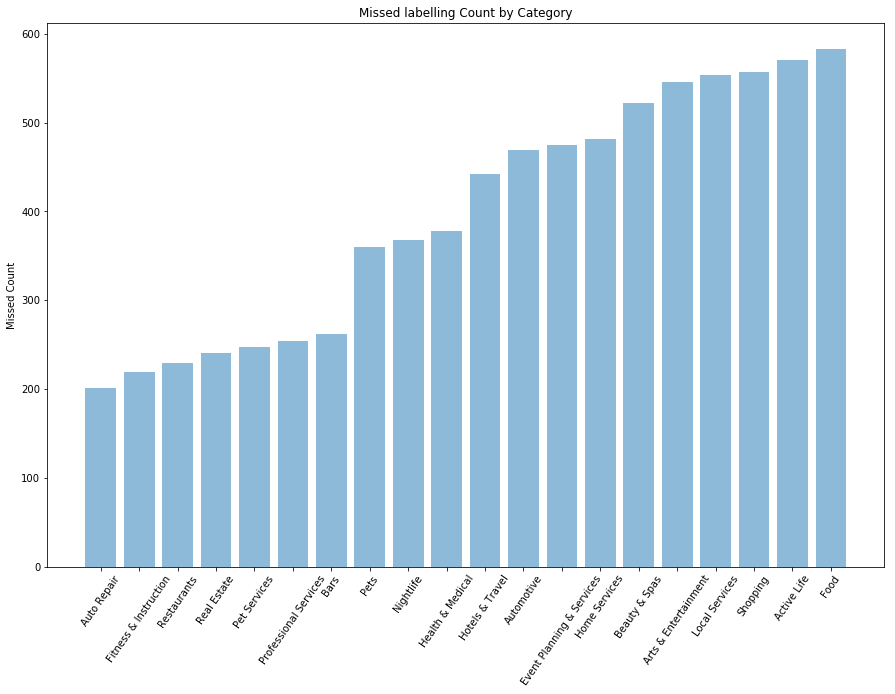

<function matplotlib.pyplot.savefig>

In [357]:
x_cat = []
y_count = []
for item in sorted(missed_count_map.items(), key=lambda x:x[1])[-20:]:
    x_cat.append(item[0])
    y_count.append(item[1])

y_pos = np.arange(len(x_cat))
 
plt.figure( figsize=(15,10))
plt.bar(y_pos, y_count, align='center', alpha=0.5)
plt.xticks(y_pos, x_cat, rotation=55)
plt.ylabel('Missed Count')
plt.title('Missed labelling Count by Category')
plt.show()
plt.savefig

In [337]:
for miss in miss_cat:
    print (sorted_cat[miss], miss_cat[miss])

Restaurants 361
Shopping 814
Food 1171
Beauty & Spas 782
Home Services 605
Nightlife 1016
Health & Medical 542
Bars 966
Automotive 584
Local Services 804
Event Planning & Services 1059
Active Life 771
Fashion 583
American (Traditional) 813
Pizza 547
Fast Food 746
Sandwiches 717
Coffee & Tea 915
Arts & Entertainment 926
Hair Salons 338
Hotels & Travel 622
Italian 771
Home & Garden 567
Auto Repair 300
Burgers 669
Mexican 593
Chinese 507
American (New) 735
Doctors 261
Breakfast & Brunch 598
Nail Salons 317
Real Estate 393
Specialty Food 716
Fitness & Instruction 367
Professional Services 411
Pets 392
Grocery 647
Bakeries 571
Cafes 573
Dentists 121
Hotels 266
Hair Removal 338
Women's Clothing 398
Desserts 387
Skin Care 379
Japanese 414
Ice Cream & Frozen Yogurt 388
Day Spas 282
Pet Services 283
Pubs 494


In [124]:
pred = clf.predict([X_train[1]])[0]
pred
pred_cat = [j for j in range(len(pred)) if pred[j] == 1]

In [213]:
nn_idx = clf.radius_neighbors([X_train[1140]], return_distance=False)
print (nn_idx)
y_pred = np.sum([Y_train[i] for i in nn_idx], axis=0)

[ array([1273,   99, 1140, 3077, 4443,  735, 4761, 4714, 6285, 6972, 7593,
       7966, 8253], dtype=int64)]


In [338]:
len(X_train)

34898

In [339]:
len(X)

69796